In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Sample Inputs
L = 12  # Fund life in years
TVPI = 1.8  # Total Value to Paid-In
duration = 5.5 # Duration of cash flows as a fraction of fund life
contribution_rate = [0.25, 0.33] + [0.50] * (L - 2)  # Capital calls schedule
initial_nav = 0  # Initial NAV
CC = 100  # Total committed capital
B = 0.5  # Bow factor
G_mean = 0.1  # Average growth rate
num_periods = 10  # Number of periods

# Parameters for Monte Carlo Simulation
num_simulations = 1000
alpha = 0.5  # Speed of reversion
b = 0.05  # Long-term mean
sigma = 0.05  # Volatility
r0 = 0.03  # Initial value (interest rate or inflation)

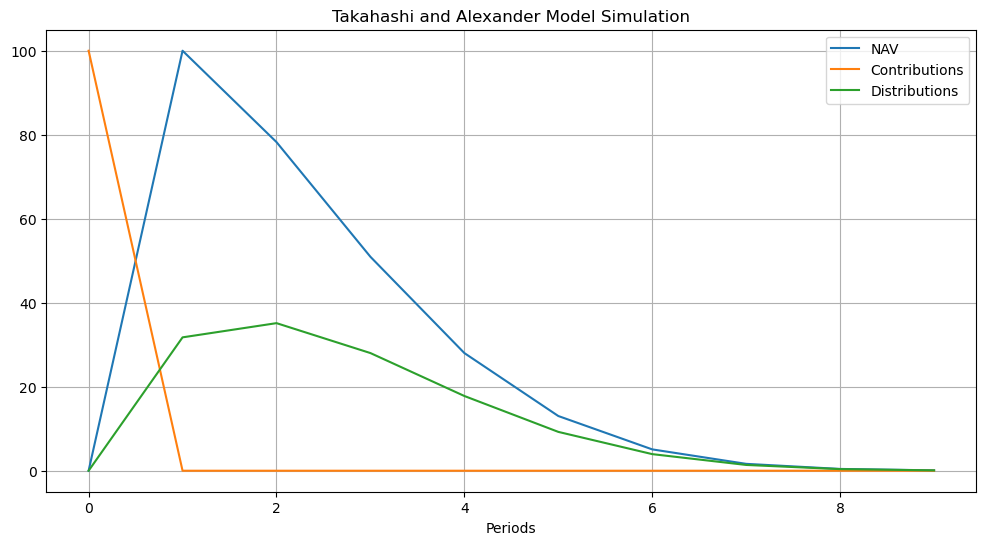

In [7]:
def simulate_TA_model(L, B, G, CC, num_periods):
    RC = np.linspace(1, 0, num_periods)  # Simplified RC that linearly decreases
    PIC = np.zeros(num_periods)
    NAV = np.zeros(num_periods + 1)
    D = np.zeros(num_periods)
    C = np.zeros(num_periods)
    
    NAV[0] = 0  # Assuming initial NAV is zero
    
    for t in range(num_periods):
        if t > 0:
            PIC[t] = PIC[t-1] + C[t-1]  # Update paid-in capital
        C[t] = RC[t] * (CC - PIC[t])  # Calculate contributions
        D[t] = ((t / L)**B) * NAV[t] * (1 + G)  # Calculate distributions
        NAV[t+1] = NAV[t] * (1 + G) + C[t] - D[t]  # Update NAV
    
    return NAV, C, D


NAV, C, D = simulate_TA_model(L, B, G_mean, CC, num_periods)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(NAV[:-1], label='NAV')
plt.plot(C, label='Contributions')
plt.plot(D, label='Distributions')
plt.title('Takahashi and Alexander Model Simulation')
plt.xlabel('Periods')
plt.legend()
plt.grid(True)
plt.show()

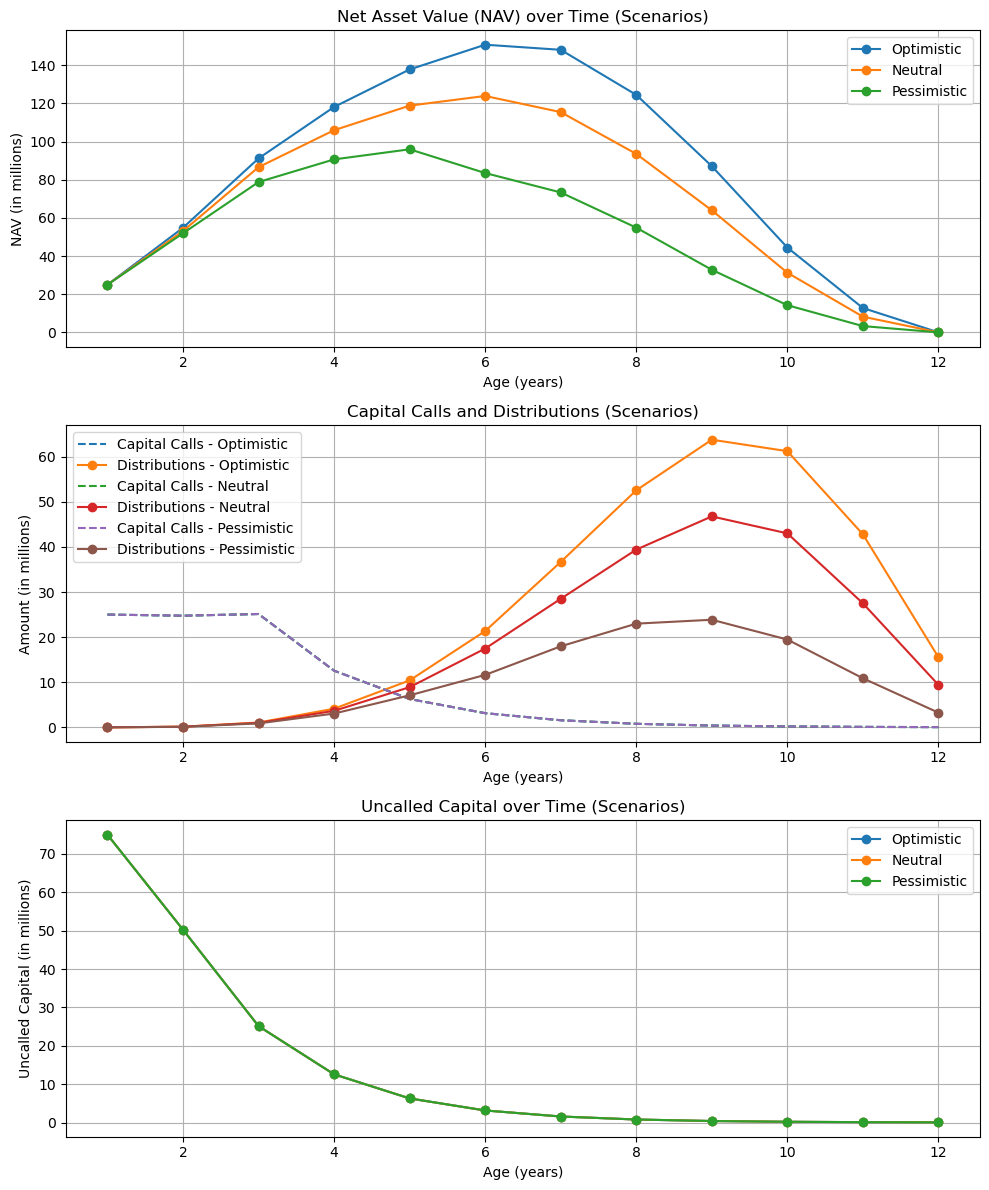

In [4]:
def calculate_bow_from_tvpi(TVPI, duration, life):
    """Calculate the bow parameter based on TVPI and duration."""
    return (1 / np.sqrt(2)) * np.exp(np.pi * duration / life)

def run_scenario_ta_model(life, TVPI, initial_nav, uncalled_capital, contribution_rate, duration, growth_rate_range):
    """
    Run the enhanced TA model for a given growth rate range (scenario-based).
    
    Parameters:
    - growth_rate_range: A tuple (min, max) specifying the range of growth rates.
    """
    # Initialize data structures
    nav = np.zeros(life + 1)
    uncalled_capital_arr = np.zeros(life + 1)
    capital_calls = np.zeros(life)
    distributions = np.zeros(life)
    
    nav[0] = initial_nav
    uncalled_capital_arr[0] = uncalled_capital
    
    # Randomize growth rate within the provided range
    growth_rate = np.random.uniform(growth_rate_range[0], growth_rate_range[1], life)
    
    # Calculate bow parameter from TVPI and duration
    bow = calculate_bow_from_tvpi(TVPI, duration, life)
    
    # Calculate distribution rate (RD) function using bow parameter
    rd = np.array([(t / life) ** bow for t in range(1, life + 1)])
    
    for t in range(life):
        # Capital Calls
        capital_calls[t] = uncalled_capital_arr[t] * contribution_rate[t]
        
        # Distributions based on NAV, Growth, and Distribution Rate
        distributions[t] = nav[t] * (1 + growth_rate[t]) * rd[t]
        
        # Update NAV and Uncalled Capital
        nav[t + 1] = nav[t] * (1 + growth_rate[t]) + capital_calls[t] - distributions[t]
        uncalled_capital_arr[t + 1] = uncalled_capital_arr[t] - capital_calls[t]
    
    # Create a DataFrame to store results
    df = pd.DataFrame({
        'Age': np.arange(1, life + 1),
        'NAV': nav[1:],
        'Capital Calls': capital_calls,
        'Distributions': distributions,
        'Uncalled Capital': uncalled_capital_arr[1:],
        'Growth Rate': growth_rate
    })
    
    return df, bow

def plot_scenario_comparison(df_scenarios, scenario_labels):
    """Plot comparison of multiple scenarios."""
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot NAV over time for each scenario
    for df, label in zip(df_scenarios, scenario_labels):
        axs[0].plot(df['Age'], df['NAV'], label=label, marker='o')

    axs[0].set_title('Net Asset Value (NAV) over Time (Scenarios)')
    axs[0].set_xlabel('Age (years)')
    axs[0].set_ylabel('NAV (in millions)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Capital Calls and Distributions for each scenario
    for df, label in zip(df_scenarios, scenario_labels):
        axs[1].plot(df['Age'], df['Capital Calls'], label=f'Capital Calls - {label}', linestyle='--')
        axs[1].plot(df['Age'], df['Distributions'], label=f'Distributions - {label}', marker='o')

    axs[1].set_title('Capital Calls and Distributions (Scenarios)')
    axs[1].set_xlabel('Age (years)')
    axs[1].set_ylabel('Amount (in millions)')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Uncalled Capital for each scenario
    for df, label in zip(df_scenarios, scenario_labels):
        axs[2].plot(df['Age'], df['Uncalled Capital'], label=label, marker='o')

    axs[2].set_title('Uncalled Capital over Time (Scenarios)')
    axs[2].set_xlabel('Age (years)')
    axs[2].set_ylabel('Uncalled Capital (in millions)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

# Sample Inputs
L = 12  # Fund life in years
TVPI = 1.8  # Total Value to Paid-In
duration = 5.5 # Duration of cash flows as a fraction of fund life
contribution_rate = [0.25, 0.33] + [0.50] * (L - 2)  # Capital calls schedule
initial_nav = 0  # Initial NAV
CC = 100  # Total committed capital
B = 2  # Bow factor
G_mean = 0.1  # Average growth rate

# Parameters for Monte Carlo Simulation
num_simulations = 1000
num_periods = 10  # Number of periods

# Vasicek model parameters for stochastic macro drivers
alpha = 0.5  # Speed of reversion
b = 0.05  # Long-term mean
sigma = 0.05  # Volatility
r0 = 0.03  # Initial value (interest rate or inflation)

# Define scenarios: optimistic, neutral, and pessimistic
scenarios = {
    'Optimistic': (0.18, 0.25),  # Higher growth rate
    'Neutral': (0.12, 0.18),     # Moderate growth rate
    'Pessimistic': (-0.05, 0.12)  # Lower growth rate
}

# Run the model for each scenario
df_scenarios = []
scenario_labels = []
for label, growth_range in scenarios.items():
    df, _ = run_scenario_ta_model(L, TVPI, initial_nav, CC, contribution_rate, duration, growth_range)
    df_scenarios.append(df)
    scenario_labels.append(label)

# Plot scenario comparison
plot_scenario_comparison(df_scenarios, scenario_labels)


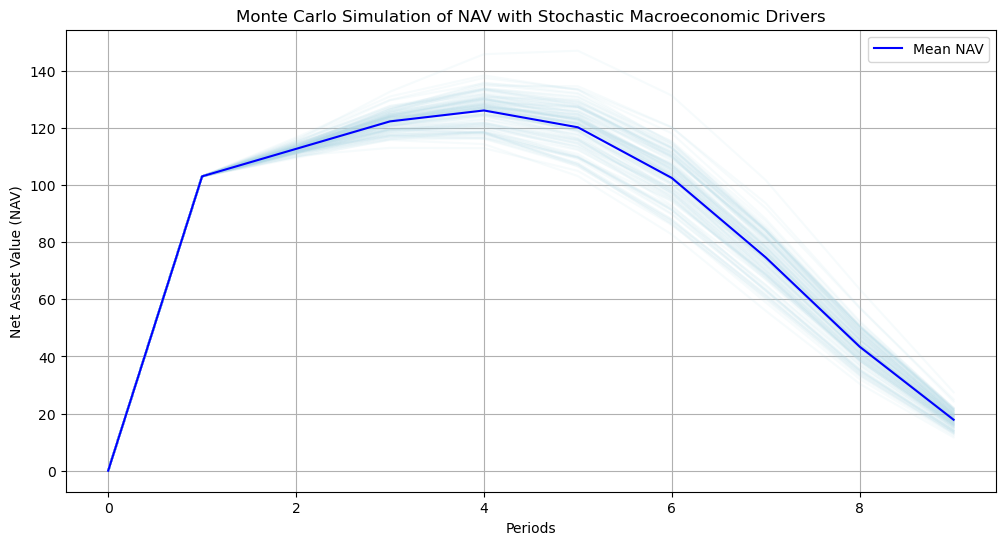

In [5]:
# Vasicek Model for stochastic interest rates or macro variables
def vasicek_model(r0, alpha, b, sigma, T, dt=1/12):
    """
    Vasicek model for interest rates or inflation.
    r0: Initial value
    alpha: Speed of mean reversion
    b: Long-term mean
    sigma: Volatility
    T: Total time (years)
    dt: Time step
    """
    n = int(T / dt)
    rates = np.zeros(n)
    rates[0] = r0
    for t in range(1, n):
        rates[t] = rates[t-1] + alpha * (b - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return rates

# Simulate the T.A. Model with stochastic macroeconomic variables
def simulate_stochastic_TA_model(L, B, G_mean, CC, num_periods, macro_drivers):
    RC = np.linspace(1, 0, num_periods)  # Simplified RC that linearly decreases
    PIC = np.zeros(num_periods)
    NAV = np.zeros(num_periods + 1)
    D = np.zeros(num_periods)
    C = np.zeros(num_periods)
    
    # Initialize NAV
    NAV[0] = 0
    
    for t in range(num_periods):
        # Capital Call Contributions with stochastic effects (RC influenced by macro variables)
        if t > 0:
            PIC[t] = PIC[t-1] + C[t-1]
        C[t] = RC[t] * (CC - PIC[t]) * (1 + macro_drivers[t])  # Macro driver affecting contribution
        
        # Distribution influenced by macroeconomic factors
        D[t] = ((t / L) ** B) * NAV[t] * (1 + G_mean + macro_drivers[t])
        
        # Update NAV
        NAV[t+1] = NAV[t] * (1 + G_mean + macro_drivers[t]) + C[t] - D[t]
    
    return NAV, C, D

# Parameters for Monte Carlo Simulation
num_simulations = 1000
L = 10  # Fund life in years
B = 2  # Bow factor
G_mean = 0.1  # Average growth rate
CC = 100  # Total committed capital
num_periods = 10  # Number of periods

# Vasicek model parameters for stochastic macro drivers
alpha = 0.5  # Speed of reversion
b = 0.05  # Long-term mean
sigma = 0.05  # Volatility
r0 = 0.03  # Initial value (interest rate or inflation)


# Monte Carlo Simulations
NAV_simulations = []
for _ in range(num_simulations):
    # Generate a stochastic macro driver (e.g., interest rates or inflation)
    macro_drivers = vasicek_model(r0, alpha, b, sigma, L)
    
    # Simulate the T.A. model with stochastic drivers
    NAV, C, D = simulate_stochastic_TA_model(L, B, G_mean, CC, num_periods, macro_drivers)
    NAV_simulations.append(NAV)

# Convert simulations to numpy array for easy manipulation
NAV_simulations = np.array(NAV_simulations)

# Plot the results
plt.figure(figsize=(12, 6))
for i in range(min(num_simulations, 100)):  # Plot up to 100 simulations
    plt.plot(NAV_simulations[i, :-1], color='lightblue', alpha=0.1)
plt.plot(np.mean(NAV_simulations, axis=0)[:-1], color='blue', label='Mean NAV')
plt.title('Monte Carlo Simulation of NAV with Stochastic Macroeconomic Drivers')
plt.xlabel('Periods')
plt.ylabel('Net Asset Value (NAV)')
plt.grid(True)
plt.legend()
plt.show()



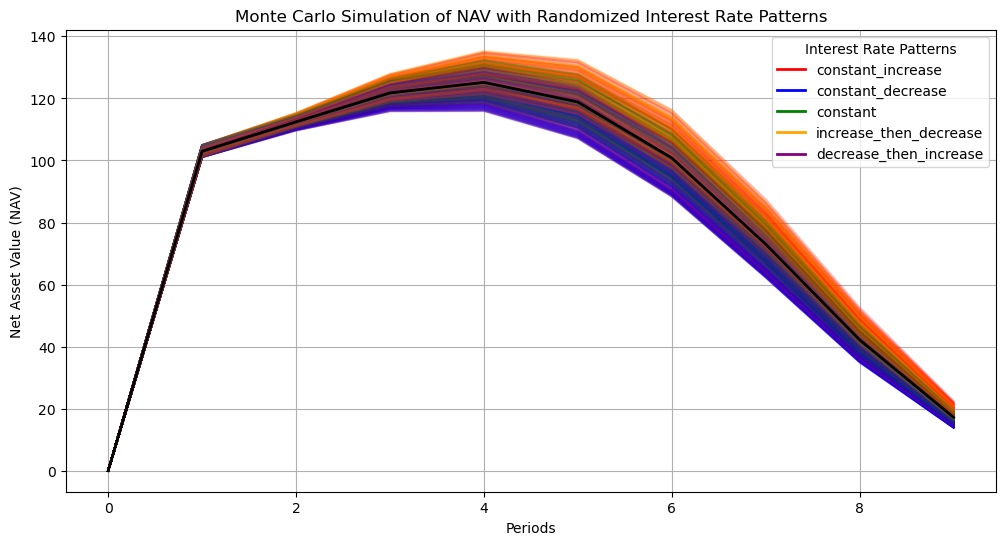

Example interest rate pattern (constant_increase): [2.5  3.   3.5  4.   4.25 4.75 5.25 5.5  6.   6.25]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define interest rate patterns
def generate_interest_rate_pattern(pattern_type, start_rate, num_periods, step_options=[0.25, 0.50]):
    rates = np.zeros(num_periods)
    rates[0] = start_rate
    half_period = num_periods // 2
    
    for t in range(1, num_periods):
        step = random.choice(step_options)
        
        if pattern_type == 'constant_increase':
            rates[t] = rates[t-1] + step
        elif pattern_type == 'constant_decrease':
            rates[t] = max(0, rates[t-1] - step)
        elif pattern_type == 'constant':
            rates[t] = rates[t-1]
        elif pattern_type == 'increase_then_decrease':
            if t <= half_period:
                rates[t] = rates[t-1] + step
            else:
                rates[t] = max(0, rates[t-1] - step)
        elif pattern_type == 'decrease_then_increase':
            if t <= half_period:
                rates[t] = max(0, rates[t-1] - step)
            else:
                rates[t] = rates[t-1] + step
    return rates

# Simulate the T.A. Model with stochastic interest rate patterns
def simulate_scenario_TA_model(L, B, G_mean, CC, num_periods, interest_rates):
    RC = np.linspace(1, 0, num_periods)  # Simplified RC that linearly decreases
    PIC = np.zeros(num_periods)
    NAV = np.zeros(num_periods + 1)
    D = np.zeros(num_periods)
    C = np.zeros(num_periods)
    
    NAV[0] = 0  # Initial NAV set to zero
    
    for t in range(num_periods):
        # Capital Call Contributions with stochastic effects (RC influenced by interest rates)
        if t > 0:
            PIC[t] = PIC[t-1] + C[t-1]
        C[t] = RC[t] * (CC - PIC[t]) * (1 + interest_rates[t] / 100)  # Interest rate influencing contributions
        
        # Distributions influenced by interest rates
        D[t] = ((t / L) ** B) * NAV[t] * (1 + G_mean + interest_rates[t] / 100)
        
        # Update NAV
        NAV[t+1] = NAV[t] * (1 + G_mean + interest_rates[t] / 100) + C[t] - D[t]
    
    return NAV, C, D


# Interest rate patterns options and associated colors
patterns = ['constant_increase', 'constant_decrease', 'constant', 'increase_then_decrease', 'decrease_then_increase']
pattern_colors = {
    'constant_increase': 'red',
    'constant_decrease': 'blue',
    'constant': 'green',
    'increase_then_decrease': 'orange',
    'decrease_then_increase': 'purple'
}

# Monte Carlo Simulations with randomized policy actions
NAV_simulations = []
simulation_patterns = []  # Store the pattern for each simulation
for _ in range(num_simulations):
    start_rate = random.uniform(1, 5)  # Random starting interest rate between 1% and 5%
    pattern = random.choice(patterns)  # Randomly select an interest rate pattern
    interest_rates = generate_interest_rate_pattern(pattern, start_rate, num_periods)
    
    # Simulate the T.A. model with the chosen interest rate pattern
    NAV, C, D = simulate_scenario_TA_model(L, B, G_mean, CC, num_periods, interest_rates)
    NAV_simulations.append(NAV)
    simulation_patterns.append(pattern)

# Convert simulations to numpy array for easy manipulation
NAV_simulations = np.array(NAV_simulations)

# Plot the results with different colors for each scenario
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(NAV_simulations[i, :-1], color=pattern_colors[simulation_patterns[i]], alpha=0.1)
    
# Plot the mean NAV across all simulations
plt.plot(np.mean(NAV_simulations, axis=0)[:-1], color='black', label='Mean NAV', linewidth=2)

# Set the plot title and labels
plt.title('Monte Carlo Simulation of NAV with Randomized Interest Rate Patterns')
plt.xlabel('Periods')
plt.ylabel('Net Asset Value (NAV)')
plt.grid(True)
plt.legend()

# Add legend for the scenario colors
handles = [plt.Line2D([0], [0], color=color, lw=2) for color in pattern_colors.values()]
labels = pattern_colors.keys()
plt.legend(handles, labels, title="Interest Rate Patterns")

plt.show()

# Example to print one random interest rate pattern
example_pattern = random.choice(patterns)
example_interest_rates = generate_interest_rate_pattern(example_pattern, start_rate=2.5, num_periods=num_periods)
print(f"Example interest rate pattern ({example_pattern}):", example_interest_rates)


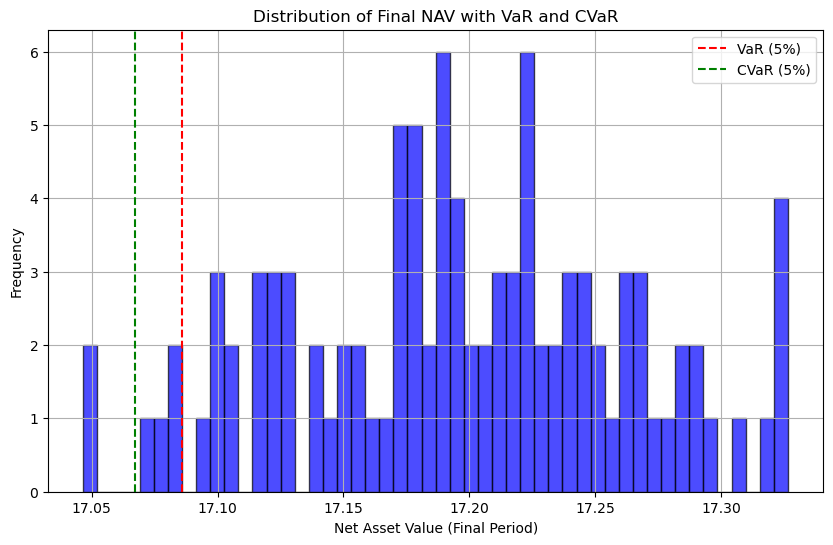

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming NAV_simulations from the previous code (shape: num_simulations x num_periods)

def bootstrap_samples(data, n_bootstrap=1000):
    """
    Bootstraps samples from the given data.
    data: The array of NAV simulations (num_simulations x num_periods).
    n_bootstrap: The number of bootstrap samples to generate.
    """
    num_simulations, num_periods = data.shape
    bootstrap_results = np.zeros((n_bootstrap, num_periods))
    
    for i in range(n_bootstrap):
        sample_indices = np.random.choice(np.arange(num_simulations), size=num_simulations, replace=True)
        bootstrap_sample = data[sample_indices]
        bootstrap_results[i] = np.mean(bootstrap_sample, axis=0)
    
    return bootstrap_results

def calculate_var_and_cvar(nav_bootstrap, confidence_level=0.95):
    """
    Calculate VaR and CVaR for each period.
    nav_bootstrap: Bootstrapped NAV samples (n_bootstrap x num_periods).
    confidence_level: The confidence level for VaR (default is 95%).
    """
    # Calculate VaR for each period
    var = np.percentile(nav_bootstrap, (1 - confidence_level) * 100, axis=0)
    
    # Initialize CVaR array
    cvar = np.zeros(nav_bootstrap.shape[1])
    
    # Calculate CVaR for each period
    for t in range(nav_bootstrap.shape[1]):
        # Filter for values below or equal to VaR for this period
        below_var = nav_bootstrap[:, t][nav_bootstrap[:, t] <= var[t]]
        
        # Calculate the mean of the values below VaR (CVaR)
        cvar[t] = np.mean(below_var)
    
    return var, cvar

# Bootstrapping the NAV simulations to build the distribution
n_bootstrap = 100  # Number of bootstrap samples
nav_bootstrap = bootstrap_samples(NAV_simulations[:, :-1], n_bootstrap=n_bootstrap)

# Calculate VaR and CVaR (5% VaR corresponds to 95% confidence)
confidence_level = 0.95
var, cvar = calculate_var_and_cvar(nav_bootstrap, confidence_level)

# Plot histogram of the last period's NAV values with VaR and CVaR
last_period_nav = nav_bootstrap[:, -1]
plt.figure(figsize=(10, 6))
plt.hist(last_period_nav, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add VaR and CVaR to histogram
plt.axvline(np.percentile(last_period_nav, (1 - confidence_level) * 100), color='red', linestyle='--', label=f'VaR (5%)')
plt.axvline(np.mean(last_period_nav[last_period_nav <= np.percentile(last_period_nav, (1 - confidence_level) * 100)]), 
            color='green', linestyle='--', label=f'CVaR (5%)')

# Add titles and labels
plt.title('Distribution of Final NAV with VaR and CVaR')
plt.xlabel('Net Asset Value (Final Period)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



-----

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Basic Takahashi and Alexander (T.A.) Model

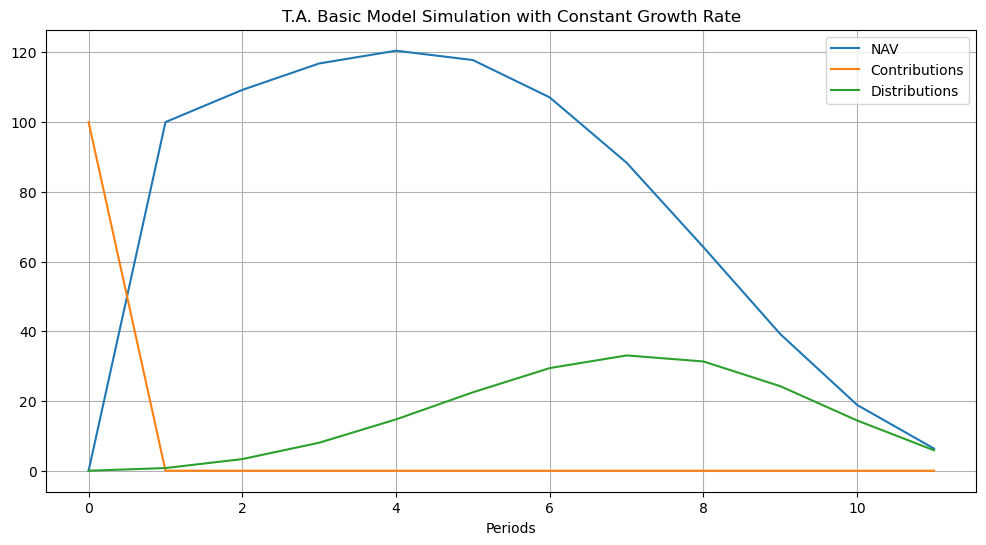

In [9]:
# Cell 1: T.A. Basic Model
import numpy as np
import matplotlib.pyplot as plt

def simulate_TA_model(L, B, G_array, CC, num_periods):
    RC = np.linspace(1, 0, num_periods)
    PIC = np.zeros(num_periods)
    NAV = np.zeros(num_periods + 1)
    D = np.zeros(num_periods)
    C = np.zeros(num_periods)
    
    NAV[0] = 0  # Initial NAV set to zero
    
    for t in range(num_periods):
        if t > 0:
            PIC[t] = PIC[t-1] + C[t-1]
        C[t] = RC[t] * (CC - PIC[t])
        D[t] = ((t / L) ** B) * NAV[t] * (1 + G_array[t])
        NAV[t+1] = NAV[t] * (1 + G_array[t]) + C[t] - D[t]
    
    return NAV, C, D

# Example fixed growth rate
G = np.full(12, 0.1)  # Constant growth rate of 10% per period

# Parameters
L = 12  # Fund life in years
B = 2   # Bow factor
CC = 100  # Total committed capital
num_periods = 12  # Number of periods

NAV, C, D = simulate_TA_model(L, B, G, CC, num_periods)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(NAV[:-1], label='NAV')
plt.plot(C, label='Contributions')
plt.plot(D, label='Distributions')
plt.title('T.A. Basic Model Simulation with Constant Growth Rate')
plt.xlabel('Periods')
plt.legend()
plt.grid(True)
plt.show()




Scenario Analysis (Optimistic, Neutral, Pessimistic Growth Rates)

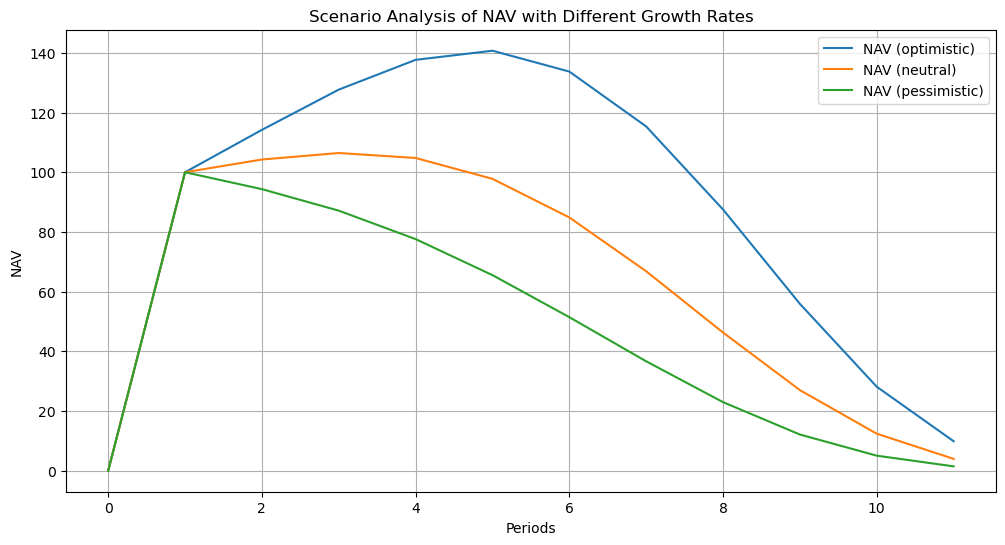

In [10]:
# Cell 2: Scenario Analysis
scenarios = {
    'optimistic': np.full(12, 0.15),
    'neutral': np.full(12, 0.05),
    'pessimistic': np.full(12, -0.05)
}

plt.figure(figsize=(12, 6))

for scenario, growth_array in scenarios.items():
    NAV, C, D = simulate_TA_model(L, B, growth_array, CC, num_periods)
    plt.plot(NAV[:-1], label=f'NAV ({scenario})')

plt.title('Scenario Analysis of NAV with Different Growth Rates')
plt.xlabel('Periods')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)
plt.show()



Monte Carlo Simulation of NAV with Macro Drivers

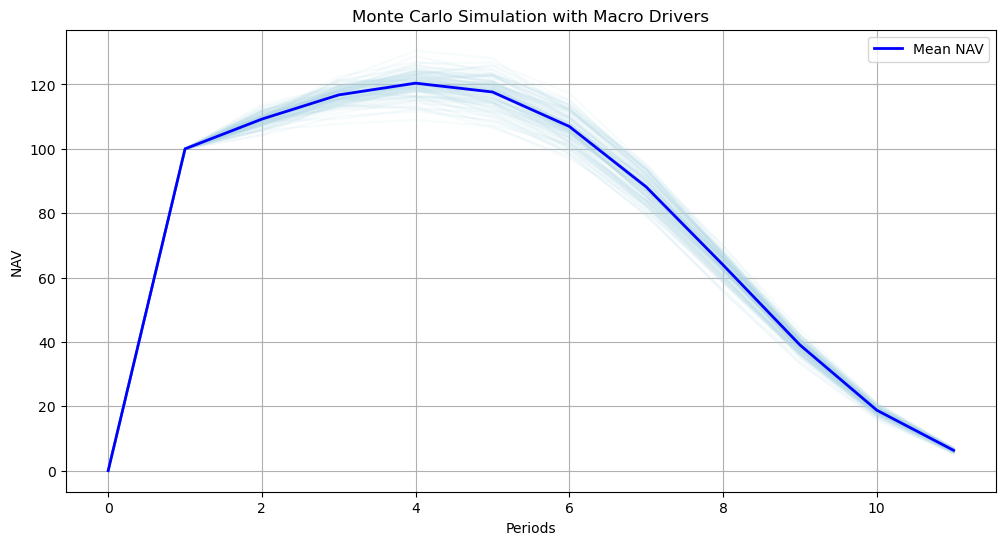

In [11]:
# Cell 3: Monte Carlo Simulation with Macro Drivers
def monte_carlo_macro_simulations(num_simulations, L, B, G_mean, CC, num_periods, macro_volatility):
    simulations = []
    for _ in range(num_simulations):
        macro_shocks = np.random.normal(G_mean, macro_volatility, num_periods)
        NAV, _, _ = simulate_TA_model(L, B, macro_shocks, CC, num_periods)
        simulations.append(NAV)
    return np.array(simulations)

num_simulations = 1000
G_mean = np.full(num_periods, 0.1)  # Mean growth rate
macro_volatility = 0.02  # 2% volatility in macro drivers
nav_simulations_macro = monte_carlo_macro_simulations(num_simulations, L, B, G_mean, CC, num_periods, macro_volatility)

# Plot Monte Carlo Results
plt.figure(figsize=(12, 6))
for sim in nav_simulations_macro[:100]:
    plt.plot(sim[:-1], color='lightblue', alpha=0.1)
plt.plot(np.mean(nav_simulations_macro, axis=0)[:-1], color='blue', label='Mean NAV', linewidth=2)
plt.title('Monte Carlo Simulation with Macro Drivers')
plt.xlabel('Periods')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.show()



Monte Carlo Simulation with Randomized Interest Rate

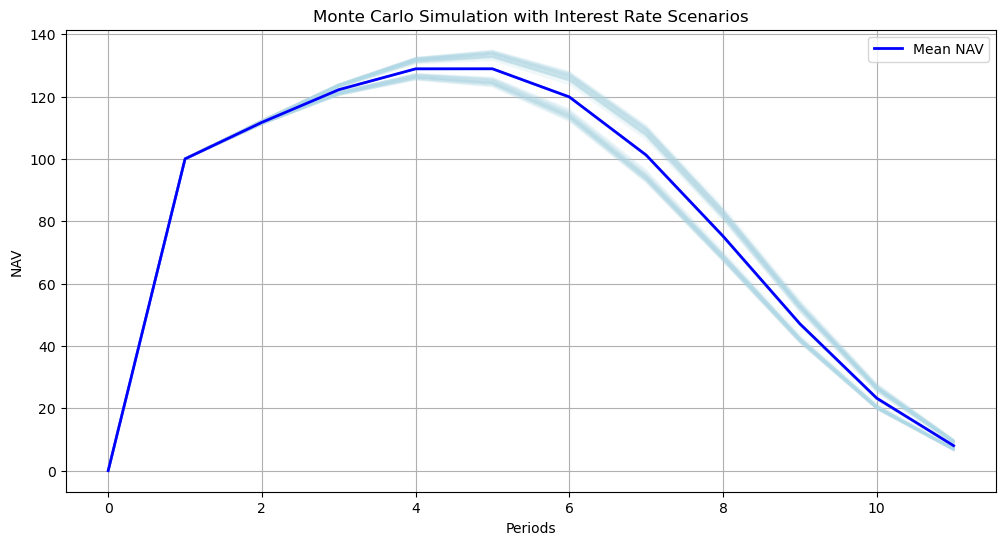

In [12]:
# Cell 4: Monte Carlo with Interest Rate Scenarios
def interest_rate_scenarios(pattern_type, start_rate, num_periods, step_options=[0.25, 0.50]):
    rates = np.zeros(num_periods)
    rates[0] = start_rate
    half_period = num_periods // 2
    
    for t in range(1, num_periods):
        step = np.random.choice(step_options)
        
        if pattern_type == 'constant_increase':
            rates[t] = rates[t-1] + step
        elif pattern_type == 'constant_decrease':
            rates[t] = max(0, rates[t-1] - step)
        elif pattern_type == 'constant':
            rates[t] = rates[t-1]
        elif pattern_type == 'increase_then_decrease':
            if t <= half_period:
                rates[t] = rates[t-1] + step
            else:
                rates[t] = max(0, rates[t-1] - step)
        elif pattern_type == 'decrease_then_increase':
            if t <= half_period:
                rates[t] = max(0, rates[t-1] - step)
            else:
                rates[t] = rates[t-1] + step
    return rates

# Simulate NAV based on interest rate scenarios
patterns = ['constant_increase', 'constant_decrease', 'constant', 'increase_then_decrease', 'decrease_then_increase']
num_simulations = 1000
nav_simulations_ir = []
for _ in range(num_simulations):
    pattern = np.random.choice(patterns)
    rates = interest_rate_scenarios(pattern, 2.5, num_periods)
    NAV, _, _ = simulate_TA_model(L, B, G + rates / 100, CC, num_periods)
    nav_simulations_ir.append(NAV)

# Plot Monte Carlo Results with Interest Rate Scenarios
plt.figure(figsize=(12, 6))
for sim in nav_simulations_ir[:100]:
    plt.plot(sim[:-1], color='lightblue', alpha=0.1)
plt.plot(np.mean(nav_simulations_ir, axis=0)[:-1], color='blue', label='Mean NAV', linewidth=2)
plt.title('Monte Carlo Simulation with Interest Rate Scenarios')
plt.xlabel('Periods')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.show()




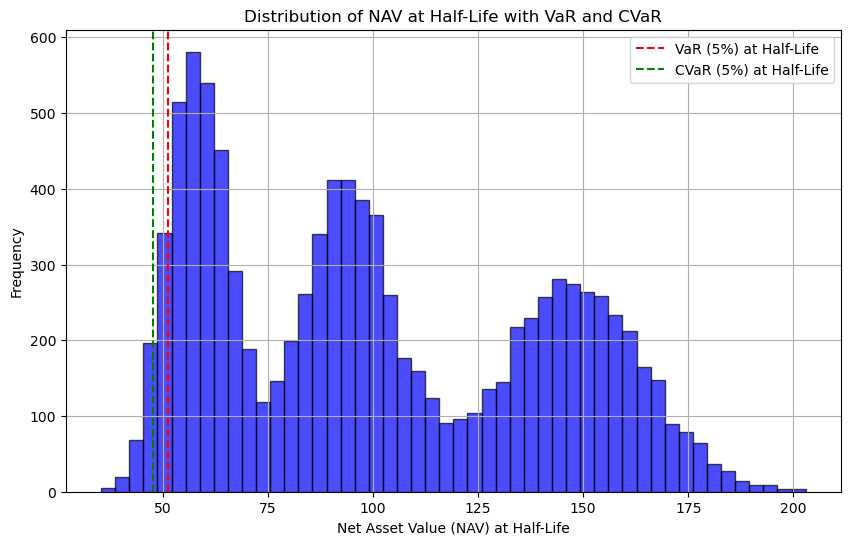

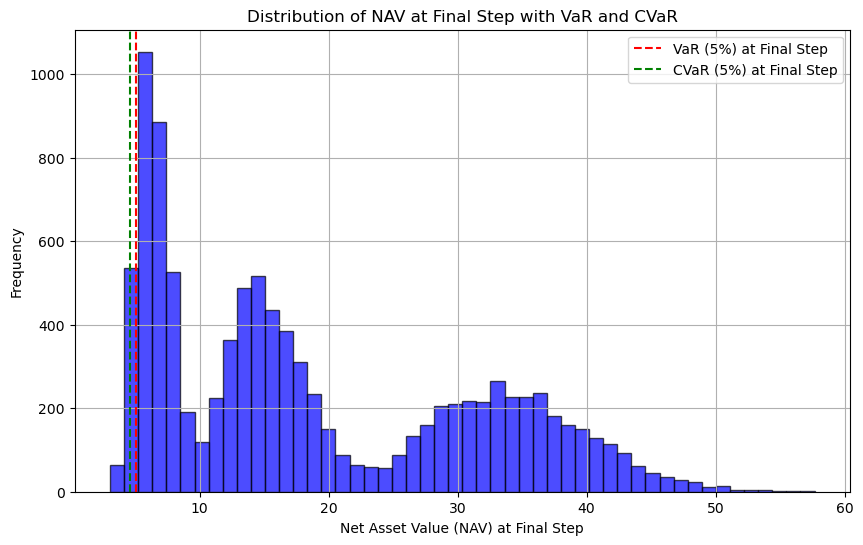

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse the T.A. model and growth rate scenarios from previous steps

def monte_carlo_simulation(num_simulations, L, B, CC, num_periods, macro_volatility, step_options):
    # Scenarios for growth rates: pessimistic, neutral, optimistic
    scenarios = {
        'pessimistic': np.full(num_periods, -0.05),
        'neutral': np.full(num_periods, 0.05),
        'optimistic': np.full(num_periods, 0.15)
    }

    # Interest rate patterns
    patterns = ['constant_increase', 'constant_decrease', 'constant', 'increase_then_decrease', 'decrease_then_increase']
    
    all_simulations = []
    
    for _ in range(num_simulations):
        # Randomly choose a growth rate scenario key and get the corresponding array
        scenario_key = np.random.choice(list(scenarios.keys()))
        growth_scenario = scenarios[scenario_key]
        
        # Generate random macro shocks for each period
        macro_shocks = np.random.normal(0, macro_volatility, num_periods)
        
        # Randomly choose an interest rate pattern
        pattern = np.random.choice(patterns)
        interest_rates = interest_rate_scenarios(pattern, 2.5, num_periods, step_options)

        # Final growth rates including macro drivers and interest rates
        final_growth_rates = growth_scenario + macro_shocks + interest_rates / 100

        # Run the simulation for this set of drivers
        NAV, _, _ = simulate_TA_model(L, B, final_growth_rates, CC, num_periods)
        all_simulations.append(NAV)
    
    return np.array(all_simulations)


# Parameters
num_simulations = 10000
macro_volatility = 0.05  # 2% volatility in macro drivers
step_options = [0.25, 0.50]  # Interest rate step options
L = 12  # Fund life in years
B = 2   # Bow factor
CC = 100  # Total committed capital
num_periods = 12  # Number of periods (same as life of the fund)

# Run the multivariate Monte Carlo simulation
nav_simulations = monte_carlo_simulation(num_simulations, L, B, CC, num_periods, macro_volatility, step_options)

# Function to compute VaR and CVaR for a given timestep
def compute_var_cvar_at_step(nav_simulations, timestep, confidence_level=0.95):
    # Extract the NAV values at the given timestep
    nav_at_timestep = nav_simulations[:, timestep]
    
    # Compute the 5% VaR
    var = np.percentile(nav_at_timestep, (1 - confidence_level) * 100)
    
    # Compute the 5% CVaR (average of the worst 5% cases)
    cvar = np.mean(nav_at_timestep[nav_at_timestep <= var])
    
    return var, cvar

# Compute VaR and CVaR at half-life and final period
half_life_step = num_periods // 2
final_step = num_periods - 2

var_half_life, cvar_half_life = compute_var_cvar_at_step(nav_simulations, half_life_step)
var_final, cvar_final = compute_var_cvar_at_step(nav_simulations, final_step)

# Plot the distribution at half-life
plt.figure(figsize=(10, 6))
plt.hist(nav_simulations[:, half_life_step], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(var_half_life, color='red', linestyle='--', label=f'VaR (5%) at Half-Life')
plt.axvline(cvar_half_life, color='green', linestyle='--', label=f'CVaR (5%) at Half-Life')
plt.title('Distribution of NAV at Half-Life with VaR and CVaR')
plt.xlabel('Net Asset Value (NAV) at Half-Life')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plot the distribution at final step
plt.figure(figsize=(10, 6))
plt.hist(nav_simulations[:, final_step], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(var_final, color='red', linestyle='--', label=f'VaR (5%) at Final Step')
plt.axvline(cvar_final, color='green', linestyle='--', label=f'CVaR (5%) at Final Step')
plt.title('Distribution of NAV at Final Step with VaR and CVaR')
plt.xlabel('Net Asset Value (NAV) at Final Step')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
